#### Notebook setup and imports

In addition to matplotlib and numpy, we will use the `dysts` library for some utilities, and the `degas` library for custom plotting.

    pip install dysts degas



In [207]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Turn on autoreload
%load_ext autoreload
%autoreload 2

from scripts.utils import smape

def smape_rolling(ts1, ts2):
    """Return the smape versus time for two time series."""
    n = min(ts1.shape[0], ts2.shape[0])
    all_smape = list()
    for i in range(1, n+1):
        smape_val = smape(ts1[:i], ts2[:i])
        all_smape.append(smape_val)
    return np.array(all_smape)

def vpt(arr, threshold=30):
    """
    Find the first time index at which an array exceeds a threshold.

    Args:
        arr (np.ndarray): The array to search. The first dimension should be a horizoned
            smape series.
        threshold (float): The threshold to search for.
    r
    Returns:
        int: The first time index at which the array exceeds the threshold.
    """
    all_exceed_times = list()
    for i in range(arr.shape[1]):
        exceed_times = np.where(arr[:, i] > threshold)[0]
        if len(exceed_times) == 0:
            tind = len(arr[:, i])
        else:
            tind = exceed_times[0]
        all_exceed_times.append(tind)
    return all_exceed_times

def nrmse(x, xhat):
    """
    Given a univariate forecast and ground truth, compute the NRMSE.
    
    Args:
        x (np.ndarray): The ground truth, a time series of shape (nt, d).
        xhat (np.ndarray): The forecast, a time series of shape (nt, d).

    Returns:
        float: The NRMSE.
    """
    denom = np.var(x, axis=1)
    numerator = np.linalg.norm(x - xhat, axis=1) ** 2
    return np.sqrt(np.mean(numerator / denom, axis=0))

def horizoned_nrmse(x, xhat):
    """Given a horizoned forecast and ground truth, compute the NRMSE as a function of time"""
    nt = min(x.shape[0], xhat.shape[0])
    nrmse_vals = list()
    for i in range(1, nt+1):
        nrmse_vals.append(nrmse(x[:i], xhat[:i]))
    nrmse_vals = np.array(nrmse_vals)
    return nrmse_vals

def horizoned_smape(x, xhat):
    """Given a horizoned forecast and ground truth, compute the SMAPE as a function of time"""
    nt = min(x.shape[0], xhat.shape[0])
    smape_vals = list()
    for i in range(1, nt+1):
        smape_vals.append(smape(x[:i], xhat[:i]))
    smape_vals = np.array(smape_vals)
    return smape_vals

def vpt_smape(x, xhat, threshold=30):
    """
    Find the first time index at which an array exceeds a threshold.

    Args:
        arr (np.ndarray): The array to search. The first dimension should be a horizoned
            smape series.
        threshold (float): The threshold to search for.

    Returns:
        int: The first time index at which the array exceeds the threshold.
    """
    arr = horizoned_smape(x, xhat)
    exceed_times = np.where(arr > threshold)[0]
    if len(exceed_times) == 0:
        tind = len(arr)
    else:
        tind = exceed_times[0]
    return tind

def vpt_nrmse(x, xhat, threshold=0.5):
    """
    Find the first time index at which an array exceeds a threshold.

    Args:
        arr (np.ndarray): The array to search. The first dimension should be a horizoned
            smape series.
        threshold (float): The threshold to search for.
    r
    Returns:
        int: The first time index at which the array exceeds the threshold.
    """
    arr = horizoned_nrmse(x, xhat)
    exceed_times = np.where(arr > threshold)[0]
    if len(exceed_times) == 0:
        tind = len(arr)
    else:
        tind = exceed_times[0]
    return tind


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plot chronos benchmark results

# Properties across many models

#### First, let's load all of the zero-shot forecasting results. This will take a few minutes

In [210]:
from dysts.base import get_attractor_list
import os

model_sizes = ["tiny", "mini", "small", "base", "large"]
all_traces, all_vpt  = dict(), dict()
granularity = 30
BASE_DIR = "./zero-shot/chronos_benchmarks_context_512_granularity_30/"

equation_names = get_attractor_list()
for equation_name in equation_names:
# for equation_name in ["Lorenz", "Aizawa", "Arneodo", "ArnoldBeltrami", "AnishchenkoAstakhov", "Rossler"]:
    
    all_vpt[equation_name] = dict()
    all_traces[equation_name] = dict()
    for model_size in model_sizes:
        try:
            all_traj_true = np.load(BASE_DIR + f"forecast_{equation_name}_granularity{granularity}_true_chronos.npy", allow_pickle=True)
            all_traj_forecasts = np.load(BASE_DIR + 
                f"forecast_{equation_name}_{model_size}_granularity{granularity}.npy", allow_pickle=True
            )
        except:
            print(f"Skipping {equation_name} {model_size}", flush=True)
            all_vpt.pop(equation_name, None)
            all_traces.pop(equation_name, None)
            continue

        # print(all_traj_true.shape, all_traj_forecasts.shape)
        
        # print(equation_name, flush=True)

        all_smape_rolling = list()
        ## Loop over all intial conditions, accounting for the fact that some predictions may not have been computed
        for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true[:len(all_traj_forecasts)]):
            all_smape = list()
            for i in range(traj_pred.shape[1]):
                smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
                if np.all(np.isnan(smape_val)):
                    pass
                else:
                    smape_val[np.isnan(smape_val)] = 0
                all_smape.append(smape_val)
            all_smape_rolling.append(all_smape)
        all_smape_rolling = np.array(all_smape_rolling)
        ## Across replicate initial conditions, take median
        ## Across different dimensions, take mean
        all_traces[equation_name][model_size] = np.nanmedian(np.nanmean(np.copy(all_smape_rolling), axis=1), axis=0)

        try:
            all_vpt2 = list()
            for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true):
                vpt_val = vpt_smape(traj_pred.squeeze()[:traj_true.shape[0]], traj_true.squeeze())
                all_vpt2.append(vpt_val)
            
        except:
            print(f"Skipping VPT for {equation_name} {model_size}", flush=True)
            all_vpt2 = np.nan * np.ones(traj_true.shape[0])
        all_vpt[equation_name][model_size] = np.array(all_vpt2)



   
            

Skipping GlycolyticOscillation tiny
Skipping GlycolyticOscillation mini
Skipping GlycolyticOscillation small
Skipping GlycolyticOscillation base
Skipping GlycolyticOscillation large
Skipping IkedaDelay tiny
Skipping IkedaDelay mini
Skipping IkedaDelay small
Skipping IkedaDelay base
Skipping IkedaDelay large
Skipping MackeyGlass tiny
Skipping MackeyGlass mini
Skipping MackeyGlass small
Skipping MackeyGlass base
Skipping MackeyGlass large
Skipping PiecewiseCircuit tiny
Skipping PiecewiseCircuit mini
Skipping PiecewiseCircuit small
Skipping PiecewiseCircuit base
Skipping PiecewiseCircuit large
Skipping ScrollDelay tiny
Skipping ScrollDelay mini
Skipping ScrollDelay small
Skipping ScrollDelay base
Skipping ScrollDelay large
Skipping SprottDelay tiny
Skipping SprottDelay mini
Skipping SprottDelay small
Skipping SprottDelay base
Skipping SprottDelay large
Skipping StickSlipOscillator tiny
Skipping StickSlipOscillator mini
Skipping StickSlipOscillator small
Skipping StickSlipOscillator base
S

#### We next generate naive forecasts that simply consist of the first test datapoint repeated


In [104]:

all_null_traces = dict()
for equation_name in equation_names:
    all_null_traces[equation_name] = dict()
    try:
        all_traj_true = np.load(BASE_DIR + f"forecast_{equation_name}_granularity{granularity}_true_chronos.npy", allow_pickle=True)
        all_traj_forecasts  = all_traj_true[:, :1, :] * np.ones_like(all_traj_true[:1, :, :1])
    except:
        print(f"Skipping {equation_name} {model_size}", flush=True)

    ## Loop over all intial conditions, accounting for the fact that some predictions may not have been computed
    all_smape_rolling = list()
    for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true[:len(all_traj_forecasts)]):
        all_smape = list()
        for i in range(traj_pred.shape[1]):
            smape_val = np.nanmedian(np.array([smape_rolling(item, traj_true[:, i]) for item in traj_pred.T]), axis=0)
            if np.all(np.isnan(smape_val)):
                pass
            else:
                smape_val[np.isnan(smape_val)] = 0
            all_smape.append(smape_val)
        all_smape_rolling.append(all_smape)
    all_smape_rolling = np.array(all_smape_rolling)

    all_null_traces[equation_name] = np.nanmedian(np.nanmean(np.copy(all_smape_rolling), axis=1), axis=0)

Skipping GlycolyticOscillation large
Skipping IkedaDelay large
Skipping MackeyGlass large
Skipping PiecewiseCircuit large
Skipping ScrollDelay large
Skipping SprottDelay large
Skipping StickSlipOscillator large
Skipping VossDelay large


#### We plot example trajectories to spot-check that the sMAPE curve makes sense

In [106]:

for i in range(3):
    traj_true, traj_pred = all_traj_true[0, :, i], all_traj_forecasts[0, :, i, 0]
    plt.figure(figsize=(5, 2))
    plt.plot(traj_true)
    plt.plot(traj_pred)
    plt.xlabel("Time")
    plt.ylabel("Value")

    plt.figure(figsize=(5, 2))
    plt.plot(smape_rolling(traj_true, traj_pred))
    plt.xlabel("Time")
    plt.ylabel("SMAPE")

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

#### Plot forecast results averaged across models

(array([  0,  50, 100]),
 [Text(0, 0, '0'), Text(0, 50, '50'), Text(0, 100, '100')])

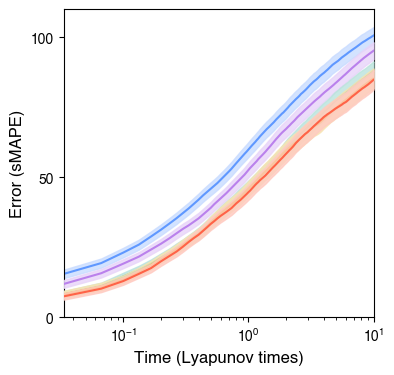

In [107]:

import degas as dg
# smape_threshold = 30
# all_all_vals, all_all_prediction_horizons = list(), list()
# for model_size in all_traces["Aizawa"].keys():
#     all_vals = list()
#     all_horizons = list()
#     for equation_name in all_traces.keys():

#         ## Save traces
#         vals = all_traces[equation_name][model_size]
#         all_vals.append(vals)

#         ## Save prediction horizon
#         exceed_times = np.where(vals > smape_threshold)[0]
#         if len(exceed_times) == 0:
#             tind = len(vals)
#         else:
#             tind = exceed_times[0]
#         all_horizons.append(tind)


#     all_all_vals.append(np.array(all_vals))
#     all_all_prediction_horizons.append(np.array(all_horizons))
# all_all_vals = np.array(all_all_vals)
# all_all_prediction_horizons = np.array(all_all_prediction_horizons)
xvals = np.arange(1, all_all_vals[0].shape[-1] + 1) / granularity

all_colors = [dg.blue,  dg.lighter(dg.purple), dg.turquoise, dg.orange,   dg.red]

# import degas as dg

plt.figure(figsize=(4, 4))
for i, model_size in enumerate(model_sizes):
    n_sys = all_all_vals.shape[1]
    mv_vals = np.mean(all_all_vals, axis=1)[i]
    std_vals = np.std(all_all_vals, axis=1)[i]

    # plt.plot(mv_vals, label=model_size)
    plt.semilogx()
    # dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys) / 1.0, x=xvals, color=all_colors[i], label=model_size)
    dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys) / 1.0, x=xvals, color=all_colors[i], label=model_size, zorder=10*i, fill_kwargs={"alpha": 0.8})

# ## Add null trace
# all_null_grouped = list()
# for equation_name in all_null_traces.keys():
#     all_null_grouped.append(all_null_traces[equation_name])
# all_null_grouped = np.array(all_null_grouped)
# mn_null = np.nanmean(all_null_grouped, axis=0)
# std_null = np.nanstd(all_null_grouped, axis=0)
# dg.plot_err(mn_null, std_null / np.sqrt(mn_null.shape[0]), 
#             x=xvals, color=(0,0,0), label=model_size, 
#             zorder=-3, fill_kwargs={"alpha": 0.8})


plt.xlabel("Time (Lyapunov times)", fontname="Helvetica", fontsize=12)
plt.ylabel("Error (sMAPE)", fontname="Helvetica", fontsize=12)
# plt.legend()
plt.xlim(np.min(xvals), np.max(xvals))
plt.ylim(0, 110)
plt.yticks([0, 50, 100])
# set font name of x-axis labels
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")

# dg.better_savefig("./fig_resources/chronos_traces.png", dpi=300)

In [223]:
all_all_prediction_horizons = list()
for model_size in all_vpt["Aizawa"].keys():
    all_vals = list()
    for equation_name in all_vpt.keys():
        all_vals.append(np.nanmean(all_vpt[equation_name][model_size]))
    all_vals = np.array(all_vals)
    all_all_prediction_horizons.append(all_vals)
all_all_prediction_horizons = np.array(all_all_prediction_horizons)

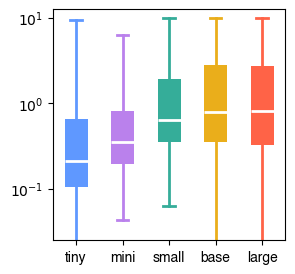

In [224]:
len(all_all_prediction_horizons)

plt.figure(figsize=(3, 3))

## Make a boxplot of the prediction horizons
# Use all_colors to color each box differently
# Boxes are very close together, so use a different color for each box
box = plt.boxplot(np.log10(all_all_prediction_horizons.T / granularity), 
                  labels=model_sizes, patch_artist=True, showfliers=False, 
                  widths=0.25, 
                  positions=np.arange(len(model_sizes))/2)
plt.xlim(-0.25, 2.25)
# plt.ylim(-0.05, 6)
for patch, color in zip(box['boxes'], all_colors):
    patch.set_facecolor(color)
    patch.set_linewidth(0)
    patch.set_edgecolor(color)

for median, color in zip(box['medians'], all_colors):
    median.set_color("w")
    median.set_linewidth(2)

for i, (cap, whisker) in enumerate(zip(box['caps'], box['whiskers'])):
    color = all_colors[i // 2]
    whisker.set_color(color)
    cap.set_color(color)
    whisker.set_linewidth(2)
    cap.set_linewidth(2)

plt.xticks(fontname="Helvetica")
plt.ylim(-1.6, 1.1)
plt.yticks([-1, 0, 1])
dg.scientific_ticks(axis='y', 
                    fontdict={"family": 'sans-serif', "fontname": "Helvetica"}
)

# plt.xlabel("Model Size")
# plt.ylabel("Prediction Horizon (Lyapunov times)")
# plt.title(f"Prediction Horizon for SMAPE > {smape_threshold}")


# dg.better_savefig("./fig_resources/legend.png", dpi=450, transparent=True)

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_87916/1261989736.py:8: RuntimeWarning: divide by zero encountered in log10
  box = plt.boxplot(np.log10(all_all_prediction_horizons.T / granularity),


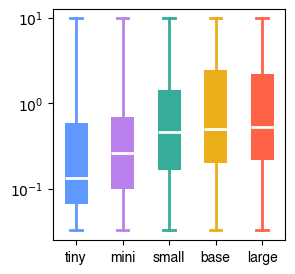

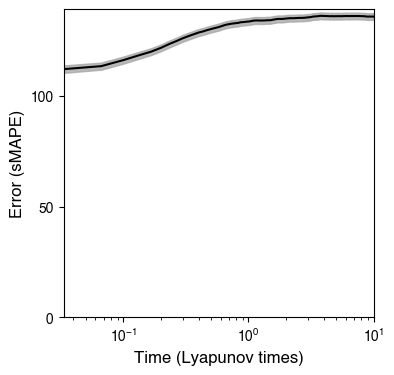

In [65]:
## Add null trace
all_null_grouped = list()
for equation_name in all_null_traces.keys():
    all_null_grouped.append(all_null_traces[equation_name])
all_null_grouped = np.array(all_null_grouped)
mn_null = np.nanmean(all_null_grouped, axis=0)
std_null = np.nanstd(all_null_grouped, axis=0)

plt.figure(figsize=(4, 4))
plt.semilogx()
dg.plot_err(mn_null, std_null / np.sqrt(mn_null.shape[0]), 
            x=xvals, color=(0,0,0), label=model_size, 
            zorder=-3, fill_kwargs={"alpha": 0.8})


plt.xlabel("Time (Lyapunov times)", fontname="Helvetica", fontsize=12)
plt.ylabel("Error (sMAPE)", fontname="Helvetica", fontsize=12)
# plt.legend()
plt.xlim(np.min(xvals), np.max(xvals))
# plt.ylim(0, 110)
plt.yticks([0, 50, 100])
# set font name of x-axis labels
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")

# dg.better_savefig("./fig_resources/naive_constant.png", dpi=450, transparent=True)

tiny


/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/dysts/analysis.py:14: UserWarning: Neurokit2 must be installed before computing multiscale entropy
  warnings.warn("Neurokit2 must be installed before computing multiscale entropy")


Skipping GlycolyticOscillation tiny
Skipping IkedaDelay tiny
Skipping MackeyGlass tiny
Skipping PiecewiseCircuit tiny
Skipping ScrollDelay tiny
Skipping SprottDelay tiny
Skipping StickSlipOscillator tiny
Skipping VossDelay tiny
mini
Skipping GlycolyticOscillation mini
Skipping IkedaDelay mini
Skipping MackeyGlass mini
Skipping PiecewiseCircuit mini
Skipping ScrollDelay mini
Skipping SprottDelay mini
Skipping StickSlipOscillator mini
Skipping VossDelay mini
small
Skipping GlycolyticOscillation small
Skipping IkedaDelay small
Skipping MackeyGlass small
Skipping PiecewiseCircuit small
Skipping ScrollDelay small
Skipping SprottDelay small
Skipping StickSlipOscillator small
Skipping VossDelay small
base
Skipping GlycolyticOscillation base
Skipping IkedaDelay base
Skipping MackeyGlass base
Skipping PiecewiseCircuit base
Skipping ScrollDelay base
Skipping SprottDelay base
Skipping StickSlipOscillator base
Skipping VossDelay base
large
Skipping GlycolyticOscillation large
Skipping IkedaDelay l

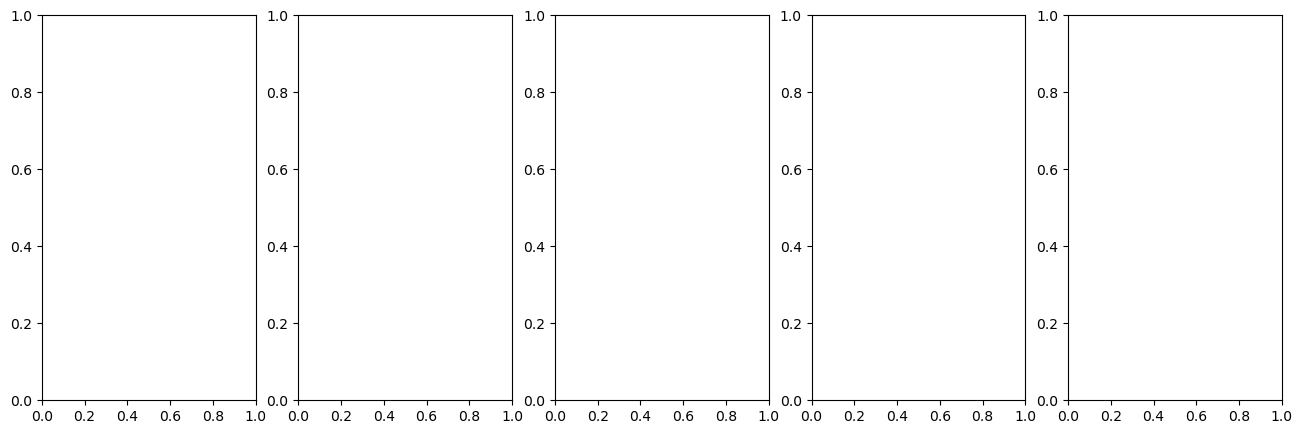

In [8]:

from scipy.stats import pearsonr, spearmanr
from dysts.analysis import gp_dim

equation_names = get_attractor_list()
fig, axes = plt.subplots(1, 5, figsize=(16, 5))  # 1 row, 4 columns

all_all_scorr = list()
for i, model_size in enumerate(model_sizes):
    print(model_size, flush=True)
    all_all_corr_true, all_all_corr_pred = list(), list()
    for equation_name in equation_names:
        try:
            all_traj_true = np.load(BASE_DIR + f"forecast_{equation_name}_granularity{granularity}_true_chronos.npy", allow_pickle=True)
            all_traj_forecasts = np.load(BASE_DIR + 
                f"forecast_{equation_name}_{model_size}_granularity{granularity}.npy", allow_pickle=True
            )
            all_traces[equation_name] = dict()
        except:
            print(f"Skipping {equation_name} {model_size}", flush=True)
            continue
        
        # all_corr_true, all_corr_pred = list(), list()
        # ## Loop over all intial conditions, accounting for the fact that some predictions may not have been computed
        # for traj_pred, traj_true in zip(
        #     all_traj_forecasts.squeeze(), 
        #     all_traj_true[:len(all_traj_forecasts)].squeeze()
        # ):
        #     corr_true = gp_dim(traj_true)
        #     corr_pred = gp_dim(traj_pred)
        #     all_corr_true.append(corr_true)
        #     all_corr_pred.append(corr_pred)
        # all_corr_true, all_corr_pred = np.array(all_corr_true), np.array(all_corr_pred)
        # all_all_corr_true.append(all_corr_true)
        # all_all_corr_pred.append(all_corr_pred)

        cdim_true, cdim_pred = gp_dim(np.vstack(all_traj_true)), gp_dim(np.vstack(all_traj_forecasts).squeeze())
        all_all_corr_true.append(cdim_true)
        all_all_corr_pred.append(cdim_pred)
    
    scorr_val = spearmanr(all_all_corr_true, all_all_corr_pred).statistic
    all_all_scorr.append(scorr_val)
    print(scorr_val, flush=True)


    
    # corr = pearsonr(np.hstack(all_all_corr_true), np.hstack(all_all_corr_pred))
    # print(corr.statistic, corr.pvalue)
    # all_scorr = list()
    # for corr_true, corr_pred in zip(all_all_corr_true, all_all_corr_pred):
    #     scorr_val = spearmanr(corr_true, corr_pred).statistic
    #     all_scorr.append(scorr_val)
    # all_all_scorr.append(np.array(all_scorr))

    # axes[i].plot(
    #     np.hstack(all_all_corr_true), 
    #     np.hstack(all_all_corr_pred),
    #     ".",
    #     color=all_colors[i]
    # )
    # axes[i].set_title(f"{model_size} {corr.statistic:.2f} {corr.pvalue:.2f}")




In [367]:
# Concatenate all forecasts into a single point cloud
cdim_true, cdim_pred = gp_dim(np.vstack(all_traj_true)), gp_dim(np.vstack(all_traj_forecasts).squeeze())

In [355]:
corr = spearmanr(np.hstack(all_all_corr_true), np.hstack(all_all_corr_pred))
print(corr.statistic, corr.pvalue, "\n", flush=True)

for item1, item2 in zip(all_all_corr_true, all_all_corr_pred):
    corr = spearmanr(item1, item2)
    print(corr.statistic, corr.pvalue)

0.7289096763657372 0.0 

0.06616541353383458 0.7816639121085741
0.2528379772961816 0.31141340050989863
0.28998968008255926 0.24309228603904504
0.3312693498452013 0.179322144399268
0.29696969696969694 0.4047016712701569
0.37941176470588234 0.14722713386289268
-0.1042311661506708 0.6806381463141873
0.1413828689370485 0.5757540929543488
0.6759545923632612 0.0020739524486674083
0.3701754385964912 0.11875173008045023
0.009287925696594427 0.9708223763257615
-0.1455108359133127 0.5645405304670836
0.3651960784313726 0.14947236965165753
0.4264705882352942 0.08780457420797669
0.12105263157894736 0.6215490254755145
-0.02456140350877193 0.9204976475735005
0.18947368421052632 0.4372149811000623
0.38333333333333336 0.30849527238037144
-0.37048503611971106 0.13016560662863333
-0.07533539731682146 0.7663922813478388
0.3357843137254902 0.1876141178747958
0.05675954592363261 0.8229893024799763
0.2606060606060606 0.4670890543863402
-0.20949432404540763 0.40410193596361976
0.22982456140350876 0.3438801731

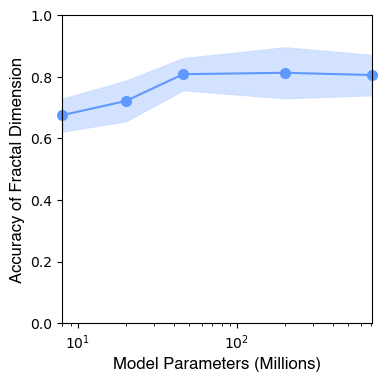

In [32]:
model_parameter_counts = np.array([8, 20, 46, 200, 710])
all_all_err = np.ones_like(model_parameter_counts) * 1 / np.sqrt(135 - 1)
# plt.semilogx(model_parameter_counts, all_all_scorr)

plt.figure(figsize=(4, 4))
plt.semilogx()
dg.plot_err(all_all_scorr, all_all_err,  x=model_parameter_counts, 
            color=dg.blue, label="Spearman Correlation", fill_kwargs={"alpha": 0.8}, clip_on=False)
plt.plot(model_parameter_counts, all_all_scorr, "o", markersize=7, color=dg.blue, clip_on=False)
plt.xlim(np.min(model_parameter_counts), np.max(model_parameter_counts))
plt.ylim(0, 1)
plt.xlabel("Model Parameters (Millions)", fontname="Helvetica", fontsize=12)
plt.ylabel("Accuracy of Fractal Dimension", fontname="Helvetica", fontsize=12)

# dg.better_savefig("./fig_resources/fractal_accuracy.png", dpi=450, transparent=True)

### Correlation between forecast and invariant properties of different dynamical systems

In [108]:

## Load the invariant properties for each individual system
import dysts.flows as dfl
all_lyap = list()
all_corrdim = list()
all_kydim = list()
all_acc = list()
for equation_name in all_traces:
    

    spec = np.array(getattr(dfl, equation_name)().lyapunov_spectrum_estimated)
    try:
        all_lyap.append(np.sum(spec[spec > 0]))
    except:
        all_lyap.append(getattr(dfl, equation_name)().maximum_lyapunov_estimated)
    # all_lyap.append(getattr(dfl, equation_name)().maximum_lyapunov_estimated)
    all_corrdim.append(getattr(dfl, equation_name)().correlation_dimension)
    all_kydim.append(getattr(dfl, equation_name)().kaplan_yorke_dimension)
    

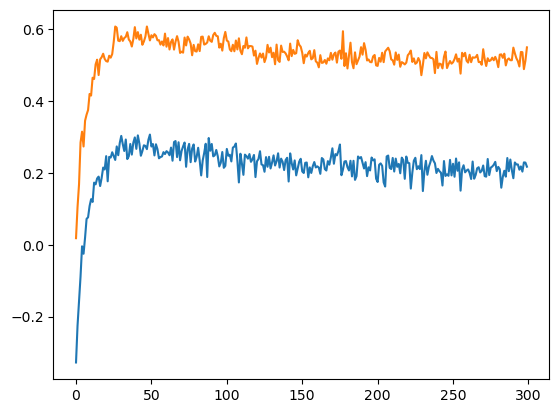

In [121]:
plt.figure(figsize=(4, 4))
for i, model_size in enumerate(model_sizes):
    n_sys = all_all_vals.shape[1]
    mv_vals = np.mean(all_all_vals, axis=1)[i]
    std_vals = np.std(all_all_vals, axis=1)[i]

    # plt.plot(mv_vals, label=model_size)
    plt.semilogx()
    # dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys) / 1.0, x=xvals, color=all_colors[i], label=model_size)
    dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys) / 1.0, x=xvals, color=all_colors[i], label=model_size, zorder=10*i, fill_kwargs={"alpha": 0.8})

# ## Add null trace
# all_null_grouped = list()
# for equation_name in all_null_traces.keys():
#     all_null_grouped.append(all_null_traces[equation_name])
# all_null_grouped = np.array(all_null_grouped)
# mn_null = np.nanmean(all_null_grouped, axis=0)
# std_null = np.nanstd(all_null_grouped, axis=0)
# dg.plot_err(mn_null, std_null / np.sqrt(mn_null.shape[0]), 
#             x=xvals, color=(0,0,0), label=model_size, 
#             zorder=-3, fill_kwargs={"alpha": 0.8})


plt.xlabel("Time (Lyapunov times)", fontname="Helvetica", fontsize=12)
plt.ylabel("Error (sMAPE)", fontname="Helvetica", fontsize=12)
# plt.legend()
plt.xlim(np.min(xvals), np.max(xvals))
plt.ylim(0, 110)
plt.yticks([0, 50, 100])
# set font name of x-axis labels
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")

tiny
mini
small
base
large


Text(0, 0.5, 'Correlation with Correlation Dimension')

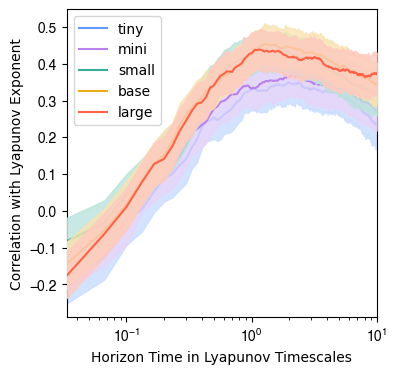

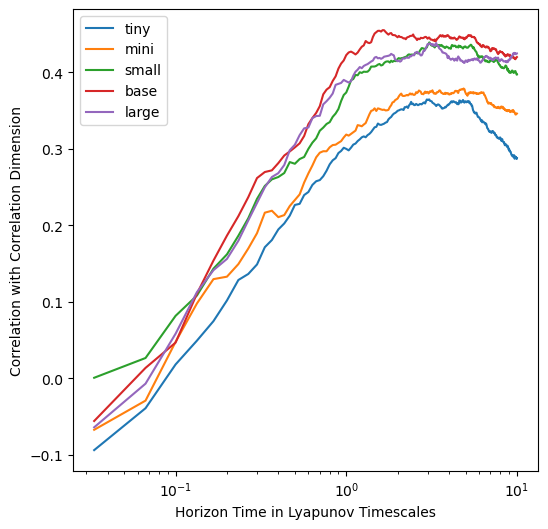

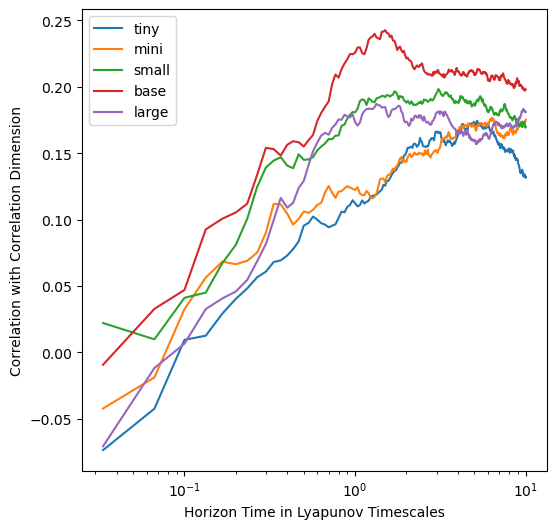

In [132]:
from scipy.stats import spearmanr

## Load the invariant properties for each individual system
plt.figure(figsize=(4, 4))
plt.semilogx()
for j, model_size in enumerate(model_sizes):
    print(model_size, flush=True)
    all_corr_lyap = list()
    all_corr_lyap_err = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_lyap, all_acc).correlation
        all_corr_bootstrap = list()
        all_corr_lyap.append(corr)

        for _ in range(1000):
            idx = np.random.choice(len(all_lyap), len(all_lyap), replace=True)
            corr_bootstrap = spearmanr(np.array(all_lyap)[idx], np.array(all_acc)[idx]).correlation
            all_corr_bootstrap.append(corr_bootstrap)
        all_corr_lyap_err.append(
            [np.percentile(all_corr_bootstrap, 50) - np.percentile(all_corr_bootstrap, 25), 
             np.percentile(all_corr_bootstrap, 75) - np.percentile(all_corr_bootstrap, 50)
        ])

    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    # plt.semilogx(xvals, all_corr_lyap, label=model_size)
    dg.plot_err(all_corr_lyap, np.array(all_corr_lyap_err), x=xvals, color=all_colors[j], 
                label=model_size, fill_kwargs={"alpha": 0.8}, zorder=10*j)
plt.xlim(xvals[0], xvals[-1])
plt.legend()
# set font name of x-axis labels
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Lyapunov Exponent")
dg.better_savefig("./fig_resources/corr_lyap.png", dpi=450, transparent=True)

plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_corrdim = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_corrdim, all_acc).correlation
        all_corr_corrdim.append(corr)
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    plt.semilogx(xvals, all_corr_corrdim, label=model_size)

plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Correlation Dimension")


plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_corrdim = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_kydim, all_acc).correlation
        all_corr_corrdim.append(corr)
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    plt.semilogx(xvals, all_corr_corrdim, label=model_size)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with KY Dimension")



In [277]:
pp = f"./trained/forecast_{"Aizawa"}_{"Linear"}_granularity{pts_per_period}.npy"
all_traj_forecasts = np.load(
                pp, allow_pickle=True
            )

FileNotFoundError: [Errno 2] No such file or directory: './trained/forecast_Aizawa_Linear_granularity30.npy'

# Baseline models

In [240]:
import glob
from dysts.base import get_attractor_list

pts_per_period = 30
model_names = np.array(["Linear", "LSTM", "NBEATS", "NVAR", "TiDE", "Transformer"])
# model_names = ["NVAR", "LSTM", "TiDE"]
all_traces, all_vpt = dict(), dict()

DIRNAME = "./trained/darts_benchmarks_granularity_30"

import glob
import os
import re
all_files = glob.glob(os.path.join(DIRNAME, f"forecast*.npy"))
equation_names = np.unique([re.search(r'forecast_(.*?)_', file_name).group(1) for file_name in all_files])
print(len(equation_names))

# equation_names = get_attractor_list()
# for equation_name in ["Lorenz", "Aizawa", "Arneodo", "ArnoldBeltrami", "AnishchenkoAstakhov", "Rossler"]:
for equation_name in equation_names:
    
    all_vpt[equation_name] = dict()
    all_traces[equation_name] = dict()
    for model_name in model_names:
        try:
            # "/Users/william/program_repos/dysts_data/benchmark_results/trained/darts_benchmarks_granularity_30/forecast_Aizawa_granularity_30_true_dysts.npy"
            traj_test_forecast = np.load(
                f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_granularity_{pts_per_period}_true_dysts.npy", 
                allow_pickle=True
            )
            all_traj_forecasts = np.load(
                f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_{model_name}_granularity{pts_per_period}.npy", 
                allow_pickle=True
            )
        except Exception as e:
            print(e)
            print(f"Skipping {equation_name} {model_name}", flush=True)
            # all_traces.pop(equation_name, None)
            # all_vpt.pop(equation_name, None)
            continue
        
        # print(equation_name, flush=True)

        all_smape_rolling = list()
        for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
            all_smape = list()
            for i in range(traj_pred.shape[1]):
                smape_val = smape_rolling(traj_pred[:, i], traj_true[:, i])
                if np.all(np.isnan(smape_val)):
                    pass
                else:
                    smape_val[np.isnan(smape_val)] = 0
                all_smape.append(smape_val)
            all_smape_rolling.append(all_smape)
        all_smape_rolling = np.array(all_smape_rolling)
        all_traces[equation_name][model_name] = np.nanmedian(np.nanmean(np.copy(all_smape_rolling), axis=1), axis=0)

        try:
            all_vpt2 = list()
            for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true):
                vpt_val = vpt_smape(traj_pred.squeeze()[:traj_true.shape[0]], traj_true.squeeze())
                all_vpt2.append(vpt_val)
        except:
            print(f"Skipping VPT for {equation_name} {model_size}", flush=True)
            all_vpt2 = np.nan * np.ones(traj_true.shape[0])
        all_vpt[equation_name][model_name] = np.array(all_vpt2)


123
Skipping VPT for ArnoldWeb large
Skipping VPT for ArnoldWeb large
Skipping VPT for ArnoldWeb large
Skipping VPT for ArnoldWeb large
Skipping VPT for ArnoldWeb large
Skipping VPT for ArnoldWeb large
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_Bouali2_Linear_granularity30.npy'
Skipping Bouali2 Linear
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_Bouali2_LSTM_granularity30.npy'
Skipping Bouali2 LSTM
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_Bouali2_Transformer_granularity30.npy'
Skipping Bouali2 Transformer
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_BurkeShaw_Linear_granularity30.npy'
Skipping BurkeShaw Linear
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_BurkeShaw_LSTM_granularity30.npy'
Skipping BurkeShaw LSTM
[Errno 2] No such file or directory: './trained/darts

(0.0, 150.0)

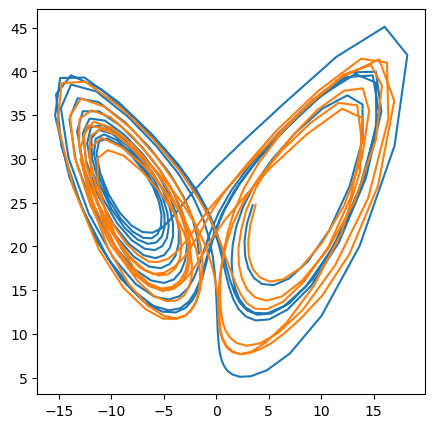

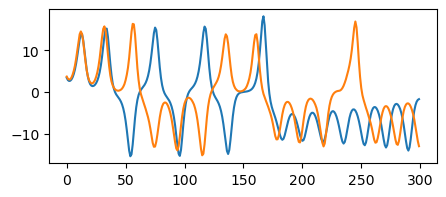

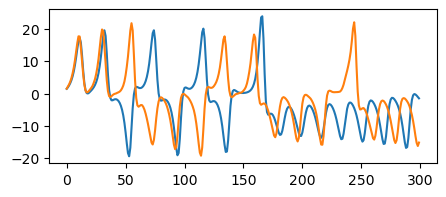

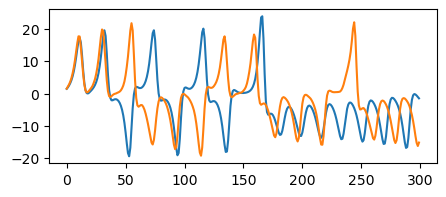

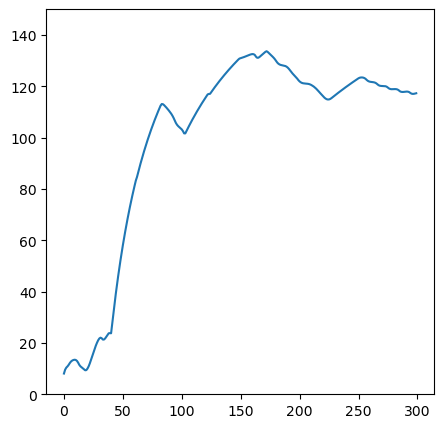

In [236]:
equation_name = "Lorenz"
model_name = "NBEATS"

traj_test_forecast = np.load(f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_granularity_{pts_per_period}_true_dysts.npy", allow_pickle=True)
all_traj_forecasts = np.load(
    f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_{model_name}_granularity{pts_per_period}.npy", allow_pickle=True
)


plt.figure(figsize=(5, 5))
plt.plot(traj_test_forecast[0, :, 0], traj_test_forecast[0, :, 2])
plt.plot(all_traj_forecasts[0, :, 0], all_traj_forecasts[0, :, 2])



plt.figure(figsize=(5, 2))
plt.plot(traj_test_forecast[0, :, 0])
plt.plot(all_traj_forecasts[0, :, 0])

plt.figure(figsize=(5, 2))
plt.plot(traj_test_forecast[0, :, 1])
plt.plot(all_traj_forecasts[0, :, 1])

plt.figure(figsize=(5, 2))
plt.plot(traj_test_forecast[0, :, 1])
plt.plot(all_traj_forecasts[0, :, 1])


plt.figure(figsize=(5, 5))
smape_vals = smape_rolling(traj_test_forecast[0, :, 0], all_traj_forecasts[0, :, 0])
plt.plot(smape_vals)
plt.ylim(0, 150)

['LSTM' 'Transformer' 'NVAR' 'Linear' 'TiDE' 'NBEATS']
LSTM 103
Transformer 121
NVAR 123
Linear 120
TiDE 123
NBEATS 123


(array([  0,  50, 100]),
 [Text(0, 0, '0'), Text(0, 50, '50'), Text(0, 100, '100')])

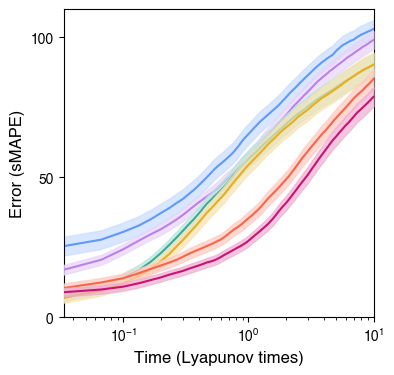

In [241]:

import degas as dg
smape_threshold = 30
# all_all_vals, all_all_prediction_horizons = list(), list()
all_vals_dict, all_predictions_dict = dict(), dict()
for model_name in model_names:
    # if model_name == "Transformer":
    #     continue
    all_vals = list()
    all_horizons = list()
    for equation_name in all_traces.keys():

        try:
            ## Save traces
            vals = all_traces[equation_name][model_name]
            all_vals.append(vals)

            ## Save prediction horizon
            exceed_times = np.where(vals > smape_threshold)[0]
            if len(exceed_times) == 0:
                tind = len(vals)
            else:
                tind = exceed_times[0]
            all_horizons.append(tind)
        except:
            pass

    all_vals_dict[model_name] = np.array(all_vals)
    all_predictions_dict[model_name] = np.array(all_horizons)
    # all_all_vals.append(np.array(all_vals))
    # all_all_prediction_horizons.append(np.array(all_horizons))
# all_all_vals = np.array(all_all_vals)
# all_all_prediction_horizons = np.array(all_all_prediction_horizons)
xvals = np.arange(1, all_vals_dict[model_names[0]].shape[-1] + 1) / pts_per_period

## Scale by granularity
all_predictions_dict = {model_name: all_predictions_dict[model_name] / pts_per_period for model_name in all_predictions_dict}

sort_order = np.argsort([np.mean(all_predictions_dict[model_name]) for model_name in all_predictions_dict])
print(model_names[sort_order])

all_colors = np.array(
    [dg.blue, dg.lighter(dg.purple), dg.turquoise, dg.orange, dg.red, dg.magenta]
)

plt.figure(figsize=(4, 4))
for i, model_name in enumerate(model_names[sort_order]):
    n_sys = all_vals_dict[model_name].shape[0]
    print(model_name, n_sys)
    # mv_vals = np.mean(all_all_vals, axis=1)[i]
    # std_vals = np.std(all_all_vals, axis=1)[i]
    mv_vals = np.mean(all_vals_dict[model_name], axis=0)
    std_vals = np.std(all_vals_dict[model_name], axis=0)
    

    # plt.plot(mv_vals, label=model_size)
    plt.semilogx()
    # dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys) / 2, x=xvals, color=all_colors[i], label=model_size)
    dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys) / 1, x=xvals, color=all_colors[i], 
                label=model_name, zorder=10*i, fill_kwargs={"alpha": 0.7})

plt.xlabel("Time (Lyapunov times)", fontname="Helvetica", fontsize=12)
plt.ylabel("Error (sMAPE)", fontname="Helvetica", fontsize=12)
# plt.legend(fontsize=10, frameon=False, prop={'family':"Helvetica", 'size':12})
# plt.legend()
plt.xlim(np.min(xvals), np.max(xvals))
plt.ylim(0, 110)
plt.yticks([0, 50, 100])
# set font name of x-axis labels
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")



# dg.better_savefig("./fig_resources/baseline_traces.png", dpi=300)

In [246]:
all_vpt["Rossler"]

{'Linear': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'LSTM': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'NBEATS': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'NVAR': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'TiDE': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'Transformer': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [232]:
all_predictions_dict.keys()

dict_keys(['large'])

In [243]:
all_predictions_dict = dict()
for model_name in all_vpt["Aizawa"].keys():
    all_vals = list()
    for equation_name in all_vpt.keys():
        all_vals.append(np.nanmean(all_vpt[equation_name][model_name]))
    all_vals = np.array(all_vals)
    all_predictions_dict[model_name] = np.array(all_vals)

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_87916/3886674819.py:5: RuntimeWarning: Mean of empty slice
  all_vals.append(np.nanmean(all_vpt[equation_name][model_name]))


KeyError: 'Linear'

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_87916/1990570437.py:5: RuntimeWarning: divide by zero encountered in log10
  [np.log10(all_predictions_dict[model_name]) for model_name in model_names[sort_order]],
/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


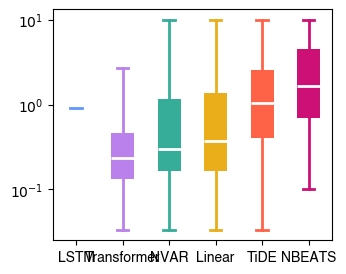

In [70]:


plt.figure(figsize=(3*(6/5), 3))

    
box = plt.boxplot(
    [np.log10(all_predictions_dict[model_name]) for model_name in model_names[sort_order]], 
    labels=model_names[sort_order], 
    patch_artist=True, showfliers=False, 
    widths=0.25,
    positions=np.arange(len(model_names))/2
)

plt.xlim(-0.25, 2.75)
for patch, color in zip(box['boxes'], all_colors):
    patch.set_facecolor(color)
    patch.set_linewidth(0)
    patch.set_edgecolor(color)

for median, color in zip(box['medians'], all_colors):
    median.set_color("w")
    median.set_linewidth(2)

for i, (cap, whisker) in enumerate(zip(box['caps'], box['whiskers'])):
    color = all_colors[i // 2]
    whisker.set_color(color)
    cap.set_color(color)
    whisker.set_linewidth(2)
    cap.set_linewidth(2)

plt.xticks(fontname="Helvetica")
plt.yticks([-1, 0, 1])
dg.scientific_ticks(axis='y', fontdict={"family": 'sans-serif', "fontname": "Helvetica"})


# Set the formatter for the x-axis
# plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# plt.xlabel("Model")
# plt.ylabel("Prediction Horizon (Lyapunov times)")
# plt.title(f"Prediction Horizon for SMAPE > {smape_threshold}")

# dg.better_savefig("./fig_resources/baselines_legend.png", dpi=450, transparent=True)


Linear
Skipping Bouali2 large
Skipping BurkeShaw large
Skipping ForcedVanDerPol large
Skipping GlycolyticOscillation large
Skipping IkedaDelay large
Skipping MacArthur large
Skipping MackeyGlass large
Skipping MultiChua large
Skipping PanXuZhou large
Skipping PehlivanWei large
Skipping PiecewiseCircuit large
Skipping Qi large
Skipping QiChen large
Skipping RabinovichFabrikant large
Skipping RayleighBenard large
Skipping RikitakeDynamo large
Skipping Rucklidge large
Skipping Sakarya large
Skipping SaltonSea large
Skipping SanUmSrisuchinwong large
Skipping ScrollDelay large
Skipping ShimizuMorioka large
Skipping SprottA large
Skipping SprottB large
Skipping SprottC large
Skipping SprottD large
Skipping SprottDelay large
Skipping SprottE large
Skipping SprottF large
Skipping SprottG large
Skipping SprottH large
Skipping SprottI large
Skipping SprottJ large
Skipping SprottJerk large
Skipping SprottK large
Skipping SprottL large
Skipping SprottM large
Skipping SprottMore large
Skipping Spro

/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/dysts/analysis.py:138: RuntimeWarning: divide by zero encountered in scalar divide
  ahat = 1 + n / np.sum(np.log(data / xmin), axis=0)


Skipping MacArthur large
Skipping MackeyGlass large
Skipping MultiChua large
Skipping NoseHoover large
Skipping PanXuZhou large
Skipping PehlivanWei large
Skipping PiecewiseCircuit large
Skipping Qi large
Skipping QiChen large
Skipping RabinovichFabrikant large
Skipping RayleighBenard large
Skipping RikitakeDynamo large
Skipping Rossler large
Skipping Rucklidge large
Skipping Sakarya large
Skipping SaltonSea large
Skipping SanUmSrisuchinwong large
Skipping ScrollDelay large
Skipping ShimizuMorioka large
Skipping SprottA large
Skipping SprottB large
Skipping SprottC large
Skipping SprottD large
Skipping SprottDelay large
Skipping SprottE large
Skipping SprottF large
Skipping SprottG large
Skipping SprottH large
Skipping SprottI large
Skipping SprottJ large
Skipping SprottJerk large
Skipping SprottK large
Skipping SprottL large
Skipping SprottM large
Skipping SprottMore large
Skipping SprottN large
Skipping SprottO large
Skipping SprottP large
Skipping SprottQ large
Skipping SprottR larg

/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4832: RuntimeWarning: invalid value encountered in subtract
  ym = y.astype(dtype) - ymean


ValueError: array must not contain infs or NaNs

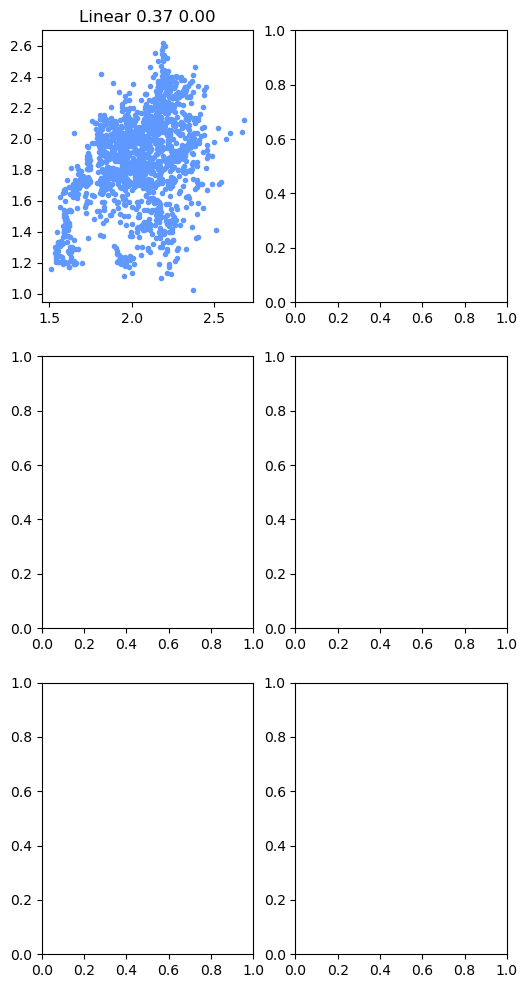

In [79]:

from scipy.stats import pearsonr
from dysts.analysis import gp_dim

equation_names = get_attractor_list()
fig, axes = plt.subplots(3, 2, figsize=(6, 12))  # 1 row, 5 columns
axes = axes.flatten()

for i, model_name in enumerate(model_names):
    print(model_name, flush=True)
    all_all_corr_true, all_all_corr_pred = list(), list()
    for equation_name in equation_names:
        try:
            all_traj_true = np.load(f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_granularity_{pts_per_period}_true_dysts.npy", allow_pickle=True)
            all_traj_forecasts = np.load(
                f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_{model_name}_granularity{pts_per_period}.npy", allow_pickle=True
            )
            all_traces[equation_name] = dict()
        except:
            print(f"Skipping {equation_name} {model_size}", flush=True)
            continue
        
        all_corr_true, all_corr_pred = list(), list()
        ## Loop over all intial conditions, accounting for the fact that some predictions may not have been computed
        for traj_pred, traj_true in zip(
            all_traj_forecasts.squeeze(), 
            all_traj_true[:len(all_traj_forecasts)].squeeze()
        ):
            corr_true, corr_pred = gp_dim(traj_true), gp_dim(traj_pred)
            all_corr_true.append(corr_true)
            all_corr_pred.append(corr_pred)
        all_corr_true, all_corr_pred = np.array(all_corr_true), np.array(all_corr_pred)
        all_all_corr_true.append(all_corr_true)
        all_all_corr_pred.append(all_corr_pred)
    # break
    
    corr = pearsonr(np.hstack(all_all_corr_true), np.hstack(all_all_corr_pred))
    print(corr.statistic, corr.pvalue)


    axes[i].plot(
        np.hstack(all_all_corr_true), 
        np.hstack(all_all_corr_pred),
        ".",
        color=all_colors[i]
    )
    axes[i].set_title(f"{model_name} {corr.statistic:.2f} {corr.pvalue:.2f}")




In [86]:
from scipy.stats import spearmanr

## Load the invariant properties for each individual system
plt.figure(figsize=(6, 6))
for model_name in model_names:
    all_corr_lyap = list()
    nt = len(all_traces[equation_name][model_name])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_name][i])
        corr = spearmanr(all_lyap, all_acc).correlation
        all_corr_lyap.append(corr)
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    plt.semilogx(xvals, all_corr_lyap, label=model_name)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Lyapunov Exponent")

plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_corrdim = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_corrdim, all_acc).correlation
        all_corr_corrdim.append(corr)
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    plt.semilogx(xvals, all_corr_corrdim, label=model_size)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Correlation Dimension")


plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_corrdim = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_kydim, all_acc).correlation
        all_corr_corrdim.append(corr)
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    plt.semilogx(xvals, all_corr_corrdim, label=model_size)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Correlation Dimension")



KeyError: 'Linear'

<Figure size 600x600 with 0 Axes>

## Statistical comparison

In [ ]:
from scipy.stats import friedmanchisquare

In [87]:
all_all_prediction_horizons

[]

In [57]:
[all_predictions_dict[key].shape for key in all_predictions_dict]

[(102,), (84,), (110,), (112,), (106,), (103,)]

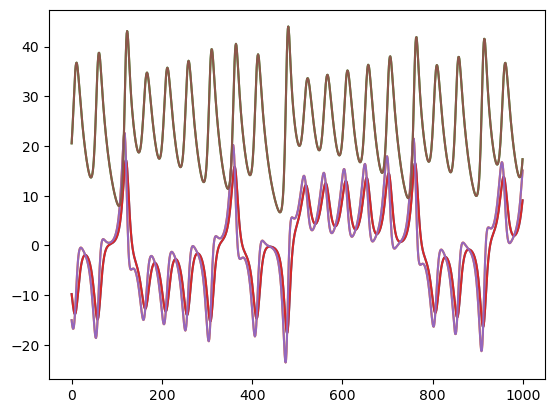

In [96]:
from dysts.flows import Lorenz

eq = Lorenz()
traj = eq.make_trajectory(1000)

eq.ic += 1e-8 * np.random.randn(*eq.ic.shape)
traj2 = eq.make_trajectory(1000)

plt.plot(traj)
plt.plot(traj2)

## Context length sweep

In [208]:

import os
from dysts.base import get_attractor_list

granularity = 30
DIRNAME = f"./zero-shot/chronos_contextsweep_context_1026_granularity_{granularity}/"





model_names = ["base"]
equation_names = get_attractor_list()
# equation_names = ["Aizawa"]
context_lengths = [5,6,8,11,15,20,26,35,47,62,82,108,144,190,252,333,441,584,773,1024]

all_traces, all_timings = dict(), dict()
for model_name in model_names:
    all_traces[model_name] = dict()
    all_timings[model_name] = dict()
    for equation_name in equation_names:
        print(equation_name, model_name, flush=True)
        all_traces[model_name][equation_name] = dict()
        all_timings[model_name][equation_name] = list()
        all_vpt = list()
        for context_length in context_lengths:
            try:
                
                fpath = os.path.join(DIRNAME, f"forecast_{equation_name}_granularity{granularity}_true_chronos.npy")
                all_traj_true = np.load(fpath, allow_pickle=True)
                # print(fpath)
                fpath = os.path.join(DIRNAME, f"forecast_{equation_name}_{model_name}_granularity{granularity}_context{context_length}.npy")
                all_traj_forecasts = np.load(fpath, allow_pickle=True)
                # print(fpath)
                
                # all_traj_forecasts = np.load(
                #     os.path.join(DIRNAME, f"forecast_{equation_name}_{model_name}_granularity{granularity}_context{context_length}.npy"), allow_pickle=True
                #     # f"./zero-shot/chronos_contextsweep_context_512_granularity_{granularity}/forecast_{equation_name}_{model_name}_granularity{granularity}_context{context_length}.npy", allow_pickle=True
                # )
            except Exception as e:
                print(e)
                print(f"Skipping {equation_name} {model_name}", flush=True)
                continue
            # break
            all_smape_rolling = list()
            for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true):
                all_smape = list()
                for i in range(traj_pred.shape[1]):
                    smape_val = smape_rolling(traj_pred[:, i], traj_true[:, i])
                    if np.all(np.isnan(smape_val)):
                        pass
                    else:
                        smape_val[np.isnan(smape_val)] = 0
                    all_smape.append(smape_val)
                all_smape_rolling.append(all_smape)

            all_smape_rolling = np.array(all_smape_rolling)
            # break


            # vpt_val = np.mean(vpt(np.nanmean(all_smape_rolling, axis=1).T))
            # all_vpt.append(vpt_val)


            # try:
            #     all_vpt2 = list()
            #     for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true):
            #         vpt_val = vpt_nrmse(traj_pred.squeeze()[:traj_true.shape[0]], traj_true.squeeze())
            #         all_vpt2.append(vpt_val)
            #     all_vpt.append(np.mean(all_vpt2))
            # except:
            #     print(f"Skipping VPT for {equation_name} {model_name}", flush=True)
            #     all_vpt.append(np.nan)


            try:
                all_vpt2 = list()
                for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true):
                    vpt_val = vpt_smape(traj_pred.squeeze()[:traj_true.shape[0]], traj_true.squeeze())
                    all_vpt2.append(vpt_val)
                all_vpt.append(np.mean(all_vpt2))
            except:
                print(f"Skipping VPT for {equation_name} {model_name}", flush=True)
                all_vpt.append(np.nan)

            

            try:
                # timings_BeerRNN_base_granularity30_context62
                fpath = os.path.join(DIRNAME, f"timings_{equation_name}_{model_name}_granularity{granularity}_context{context_length}")
                ## read single value from txt file
                val = np.loadtxt(fpath)
                all_timings[model_name][equation_name].append(val)
            except Exception as e:
                print(e)
                print(f"Skipping timings for {equation_name} {model_name}", flush=True)
                all_timings[model_name][equation_name].append(np.nan)
        # break

        all_traces[model_name][equation_name] = np.array(all_vpt)
        # break





Aizawa base


AnishchenkoAstakhov base
Arneodo base
ArnoldBeltramiChildress base
ArnoldWeb base
AtmosphericRegime base
BeerRNN base
BelousovZhabotinsky base
BickleyJet base
Blasius base
BlinkingRotlet base
BlinkingVortex base
Bouali base
Bouali2 base
BurkeShaw base
CaTwoPlus base
CaTwoPlusQuasiperiodic base
CellCycle base
Skipping VPT for CellCycle base
CellularNeuralNetwork base
Chen base
ChenLee base
Chua base
CircadianRhythm base
CoevolvingPredatorPrey base
Colpitts base
Coullet base
Dadras base
DequanLi base
DoubleGyre base
DoublePendulum base
Duffing base
ExcitableCell base
Finance base
FluidTrampoline base
ForcedBrusselator base
ForcedFitzHughNagumo base
ForcedVanDerPol base
GenesioTesi base
GlycolyticOscillation base
[Errno 2] No such file or directory: './zero-shot/chronos_contextsweep_context_1026_granularity_30/forecast_GlycolyticOscillation_granularity30_true_chronos.npy'
Skipping GlycolyticOscillation base
[Errno 2] No such file or directory: './zero-shot/chronos_contextsweep_context_102

In [297]:
equation_name = "Aizawa"
model_name = "base"
all_pred = list()
for context_length in context_lengths:
    ## Should see a slight inference cost decrease, and noticeably different forecasts
    fpath = os.path.join(DIRNAME, f"forecast_{equation_name}_{model_name}_granularity{granularity}_context{context_length}.npy")
    all_traj_forecasts = np.load(fpath, allow_pickle=True)

    all_pred.append(all_traj_forecasts)

In [35]:
plt.plot(all_pred[0][0, :, 0], all_pred[0][0, :, 2])
plt.plot(all_pred[-1][0, :, 0], all_pred[-1][0, :, 2])

NameError: name 'all_pred' is not defined

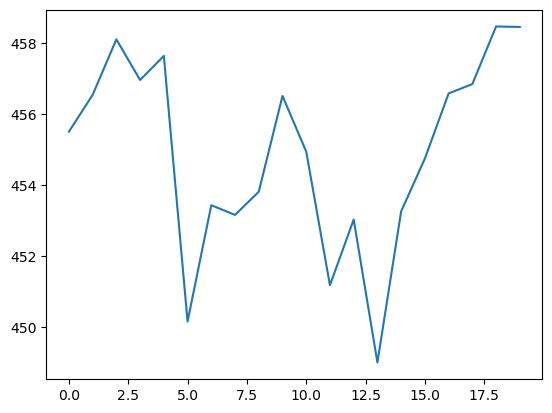

In [286]:
plt.plot(np.array(all_timings[model_name][equation_name]))

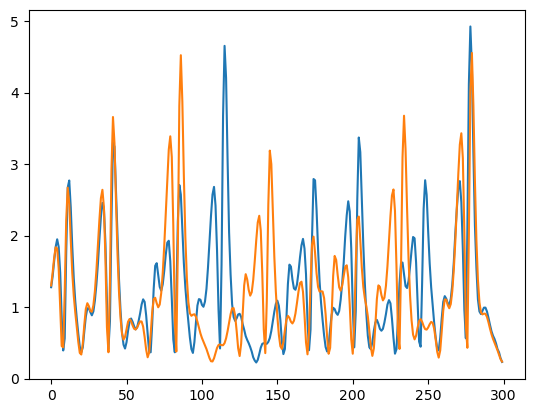

In [259]:
all_traces[model_name]

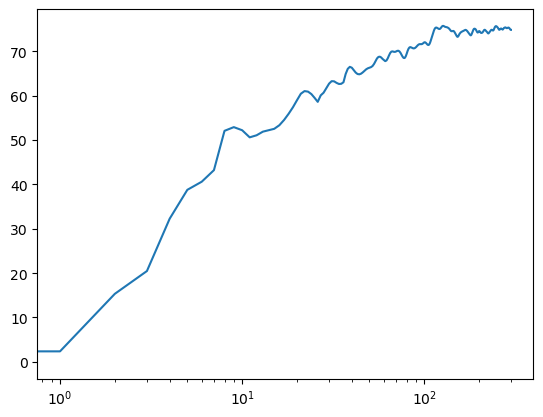

In [245]:
plt.semilogx(np.mean(np.median(all_smape_rolling, axis=1), axis=0))

Text(0, 0.5, 'VPT (Lyapunov times)')

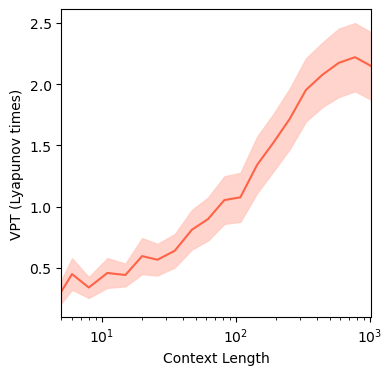

In [209]:

pts_per_period = 30
all_traces_pooled = list()
all_counts_pooled = list()
for equation_name in equation_names:
    if len(all_traces[model_name][equation_name]) == 0:
        continue
    all_traces_pooled.append(all_traces[model_name][equation_name] / pts_per_period )
    ## pad with nans to length of context_lengths
    all_counts_pooled.append(len(all_traces[model_name][equation_name]))
    n = len(context_lengths) - len(all_traces[model_name][equation_name])
    if n > 0:
        all_traces_pooled[-1] = np.pad(all_traces_pooled[-1], (0, n), "constant", constant_values=np.nan)
all_traces_pooled = np.array(all_traces_pooled)

## Bootstrap error bars
all_traces_pooled_bootstraps = list()
for _ in range(1000):
    idx = np.random.choice(np.arange(all_traces_pooled.shape[0]), all_traces_pooled.shape[0], replace=True)
    all_traces_pooled_bootstraps.append(np.nanmean(all_traces_pooled[idx], axis=0))
all_traces_pooled_bootstraps = np.array(all_traces_pooled_bootstraps)

plt.figure(figsize=(4, 4))
plt.semilogx()
# plt.semilogx(context_lengths, np.std(all_traces_pooled, axis=0) / np.sqrt(all_traces_pooled.shape[0]))
dg.plot_err(np.nanmean(all_traces_pooled, axis=0), 
            # np.array([np.percentile(all_traces_pooled, 50, axis=0) - np.percentile(all_traces_pooled_bootstraps, 25, axis=0), 
            #           np.percentile(all_traces_pooled, 75, axis=0) - np.percentile(all_traces_pooled_bootstraps, 50, axis=0)]).T,
            np.nanstd(all_traces_pooled, axis=0) / np.sqrt(all_traces_pooled.shape[0]),
            x=context_lengths, color=dg.red, label=model_name, fill_kwargs={"alpha": 0.8})
# dg.plot_err(np.nanmean(all_traces_pooled_bootstraps, axis=0), 
#             np.nanstd(all_traces_pooled_bootstraps, axis=0),
#             x=context_lengths, color=dg.red, label=model_name, fill_kwargs={"alpha": 0.8})
plt.xlim(np.min(context_lengths), np.max(context_lengths))
plt.xlabel("Context Length")
plt.ylabel("VPT (Lyapunov times)")


Text(0, 0.5, 'VPT (Lyapunov times)')

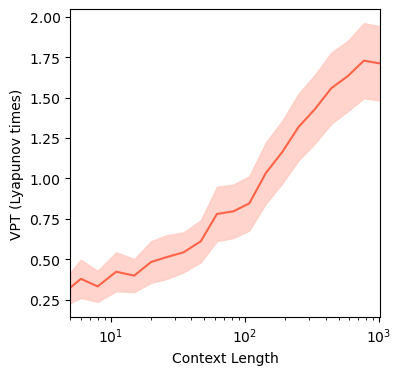

Text(0, 0.5, 'VPT (Lyapunov times)')

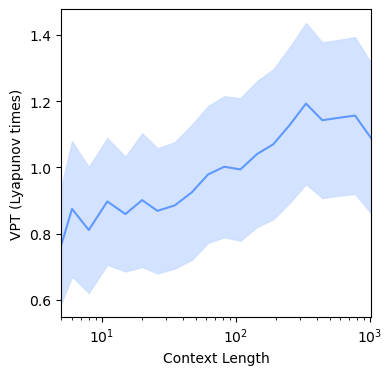

Text(0.5, 0, 'Context Length')

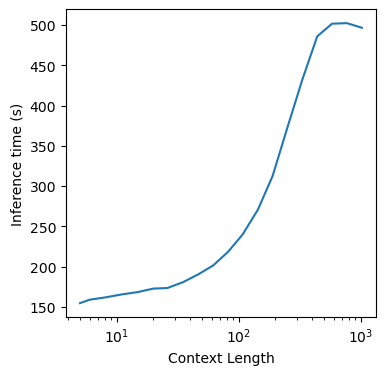

In [41]:
all_timing_pooled = list()
for equation_name in all_timings[model_name].keys():
    if len(all_timings[model_name][equation_name]) == 0:
        continue 
    all_timing_pooled.append(np.array(all_timings[model_name][equation_name]))
    ## pad with nans 
    n = len(context_lengths) - len(all_timings[model_name][equation_name])
    if n > 0:
        all_timing_pooled[-1] = np.pad(all_timing_pooled[-1], (0, n), "constant", constant_values=np.nan)
        
    
all_timing_pooled = np.array(all_timing_pooled)

plt.figure(figsize=(4, 4))
plt.semilogx(context_lengths, np.nanmean(all_timing_pooled, axis=0))
plt.ylabel("Inference time (s)")
plt.xlabel("Context Length")

In [86]:
granularity = 30
DIRNAME = f"./trained/darts_contextsweep_context_1026_granularity_{granularity}/"


model_names = ["NBEATS"]
equation_names = get_attractor_list()
# equation_names = ["Lorenz"]
context_lengths = [5,6,8,11,15,20,26,35,47,62,82,108,144,190,252,333,441,584,773,1024]

all_traces, all_timings = dict(), dict()
for model_name in model_names:
    all_traces[model_name] = dict()
    all_timings[model_name] = dict()
    for equation_name in equation_names:
        all_traces[model_name][equation_name] = dict()
        all_timings[model_name][equation_name] = list()
        all_vpt = list()
        for context_length in context_lengths:
            try:
                fpath = os.path.join(DIRNAME, f"forecast_{equation_name}_granularity_{granularity}_true_dysts.npy")
                all_traj_true = np.load(fpath, allow_pickle=True)
                print(fpath)
                fpath = os.path.join(DIRNAME, f"forecast_{equation_name}_{model_name}_granularity{granularity}_context{context_length}.npy")
                all_traj_forecasts = np.load(fpath, allow_pickle=True)
                print(fpath)

                if len(all_traj_forecasts.shape) < 3:
                    continue
                
            except Exception as e:
                print(e)
                print(f"Skipping {equation_name} {model_name}", flush=True)
                continue
            # break
            all_smape_rolling = list()
            for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true):
                all_smape = list()
                for i in range(traj_pred.shape[1]):
                    smape_val = smape_rolling(traj_pred[:, i], traj_true[:, i])
                    if np.all(np.isnan(smape_val)):
                        pass
                    else:
                        smape_val[np.isnan(smape_val)] = np.nan
                    all_smape.append(smape_val)
                all_smape_rolling.append(all_smape)

            all_smape_rolling = np.array(all_smape_rolling)
            # break

            # plt.figure()
            # plt.plot(np.nanmean(all_smape_rolling, axis=1).T)

            vpt_val = np.mean(vpt(np.nanmean(all_smape_rolling, axis=1).T))
            all_vpt.append(vpt_val)
            # break

            try:
                fpath = os.path.join(DIRNAME, f"timings_{equation_name}_{model_name}_granularity{granularity}_context{context_length}")
                ## read single value from txt file
                val = np.loadtxt(fpath)
                all_timings[model_name][equation_name].append(val)
            except Exception as e:
                print(e)
                print(f"Skipping timings for {equation_name} {model_name}", flush=True)
                all_timings[model_name][equation_name].append(np.nan)
        # break

        all_traces[model_name][equation_name] = np.array(all_vpt)
        # break


./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_granularity_30_true_dysts.npy
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_NBEATS_granularity30_context5.npy
./trained/darts_contextsweep_context_1026_granularity_30/timings_Aizawa_NBEATS_granularity30_context5 not found.
Skipping timings for Aizawa NBEATS
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_granularity_30_true_dysts.npy
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_NBEATS_granularity30_context6.npy
./trained/darts_contextsweep_context_1026_granularity_30/timings_Aizawa_NBEATS_granularity30_context6 not found.
Skipping timings for Aizawa NBEATS
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_granularity_30_true_dysts.npy
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_NBEATS_granularity30_context8.npy
./trained/darts_contextsweep_context_1026_granularity_30/timings_Aizawa_NB

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_87916/2349519121.py:53: RuntimeWarning: Mean of empty slice
  vpt_val = np.mean(vpt(np.nanmean(all_smape_rolling, axis=1).T))


./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_granularity_30_true_dysts.npy
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_NBEATS_granularity30_context190.npy
./trained/darts_contextsweep_context_1026_granularity_30/timings_Aizawa_NBEATS_granularity30_context190 not found.
Skipping timings for Aizawa NBEATS
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_granularity_30_true_dysts.npy
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_NBEATS_granularity30_context252.npy
./trained/darts_contextsweep_context_1026_granularity_30/timings_Aizawa_NBEATS_granularity30_context252 not found.
Skipping timings for Aizawa NBEATS
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_granularity_30_true_dysts.npy
./trained/darts_contextsweep_context_1026_granularity_30/forecast_Aizawa_NBEATS_granularity30_context333.npy
./trained/darts_contextsweep_context_1026_granularity_30/timings

Text(0, 0.5, 'VPT (Lyapunov times)')

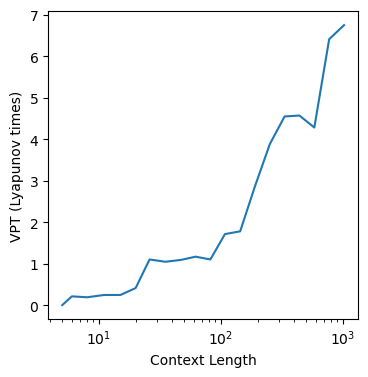

In [88]:
pts_per_period = 30
all_traces_pooled = list()
for equation_name in equation_names:
    if len(all_traces[model_name][equation_name]) == 0:
        continue
    all_traces_pooled.append(all_traces[model_name][equation_name] / pts_per_period )
    ## pad with nans to length of context_lengths
    all_counts_pooled.append(len(all_traces[model_name][equation_name]))
    n = len(context_lengths) - len(all_traces[model_name][equation_name])
    if n > 0:
        all_traces_pooled[-1] = np.pad(all_traces_pooled[-1], (0, n), "constant", constant_values=np.nan)
    all_traces_pooled[-1][0] = 0
all_traces_pooled = np.array(all_traces_pooled)

plt.figure(figsize=(4, 4))
plt.semilogx(context_lengths, np.nanmedian(all_traces_pooled, axis=0))
plt.xlabel("Context Length")
plt.ylabel("VPT (Lyapunov times)")

In [56]:
all_traces[model_name]["Aizawa"]

array([300.        ,   0.        ,   0.33333333,   0.33333333,
         0.33333333,   1.        ,  43.66666667,  31.33333333,
        34.        ,  88.33333333,  94.66666667, 122.33333333,
       122.        ,  85.66666667, 116.33333333, 148.66666667,
       137.        , 154.        , 184.        , 194.33333333])

In [92]:
fpath = os.path.join(DIRNAME, f"forecast_{equation_name}_{model_name}_granularity{granularity}_context{context_lengths[3]}.npy")
all_traj_forecasts = np.load(fpath, allow_pickle=True)



(3, 300, 3)


## Calibrate sMAPE and NRMSE threshold

In [119]:
xx, yy = np.random.normal(size=(100, 2)), np.random.normal(size=(100, 2))

# print(nrmse(xx, yy))
print(vpt_nrmse(xx, yy))


0


In [116]:
[1,2,3,4][:3]

[1, 2, 3]